<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

This notebook implements diffusion curvature atop the popular Graphtools library (also maintained by the Krishnaswamy Lab). To compute the curvature of any graphtools graph, simply instantiate a [`DiffusionCurvature`](https://professorwug.github.io/diffusion_curvature/core (graphtools).html#diffusioncurvature) object with your choice of parameters, and pass the graphtools graph through as input.

What follows is a literate implementation, showing the steps of the algorithm applied to our old friend, the torus.

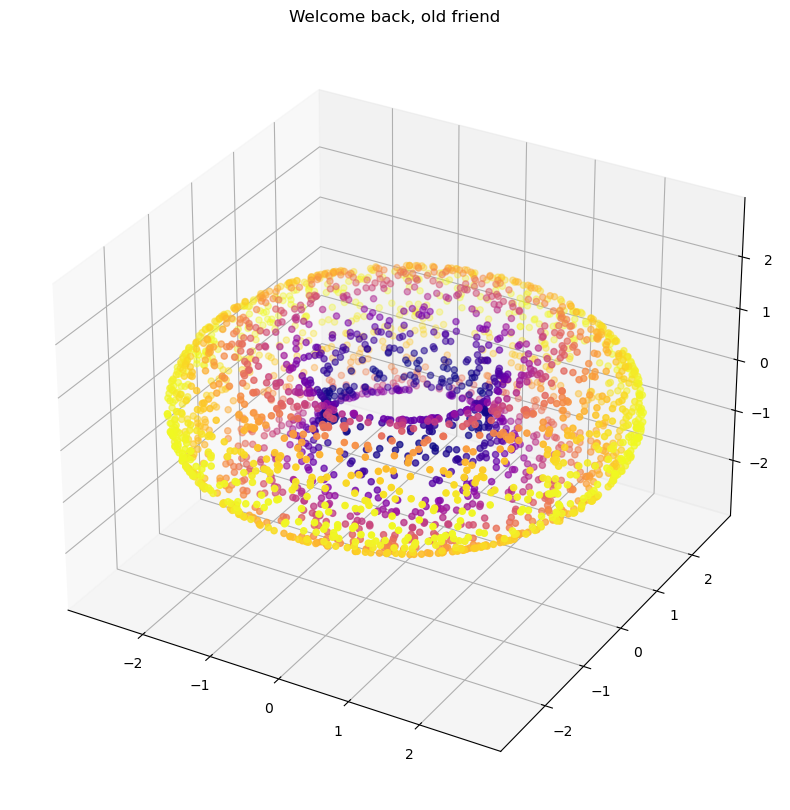

In [ ]:
from diffusion_curvature.datasets import torus
X_torus, torus_gaussian_curvature = torus(n=5000)
plot_3d(X_torus, torus_gaussian_curvature, title="Welcome back, old friend")

First we need to turn this into a graphtools graph. Fortunately, that's quite simple. We'll trust the graphtools defaults for now.

In [ ]:
import graphtools
G_torus = graphtools.Graph(X_torus, anisotropy=1,)
G_torus_landmarked = graphtools.Graph(X_torus, n_landmark=100)

Graphtools has some niceties, but also some limitations. It can, for instance, calculate the diffusion matrix, complete with anisotropic density normalization and automatic conversion into scipy's sparse matrix format. It can also compute the landmark operator - a compressed version of the diffusion matrix that diffusion only between a subset of "landmark" points within a dataset - enabling us to approximately power *huge* diffusion matrices. All of these features will be used!

In [ ]:
G_torus.P

<2491x2491 sparse matrix of type '<class 'numpy.float64'>'
	with 19117 stored elements in Compressed Sparse Row format>

## The Diffusion Curvature class
Following the convention of PyTorch modules, we separate the configuration/initialization of diffusion curvature from the operation.
First, you'll initialize the following class, then run the equivalent of a `fit_transform` function.

To better aid literate notebook-based development, the functions in the class will be attached via the fastcore `@patch` operator.
This allows us to debug them more easily.

In [1]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L17){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature

>      DiffusionCurvature (t:int, distance_type='PHATE', use_entropy:bool=False,
>                          **kwargs)

Initialize self.  See help(type(self)) for accurate signature.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| t | int |  | Number of diffusion steps to use when measuring curvature. TODO: Heuristics |
| distance_type | str | PHATE |  |
| use_entropy | bool | False | If true, uses KL Divergence instead of Wasserstein Distances. Faster, seems empirically as good, but less proven. |
| kwargs |  |  |  |

In [ ]:
DC = DiffusionCurvature(t=8)

First, we'll tackle the most computationally demanding step: powering the diffusion matrix.
Because graphtools defaults to scipy.sparse matrices, we can do this with the `**` operation, which doesn't (as in np arrays) perform elementwise operations. To be safe, we'll check if there's an np array and us `np.linalg.matrix_power` if so.

In [2]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature.power_diffusion_matrix)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L29){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature.power_diffusion_matrix

>      DiffusionCurvature.power_diffusion_matrix (G:<function Graph>, t=None)

Verifying... Does this indeed power the matrix?

In [ ]:
DC = DiffusionCurvature(t=8)
G_torus = DC.power_diffusion_matrix(G_torus)
def csr_allclose(a, b, rtol=1e-4, atol = 1e-4):
    c = np.abs(np.abs(a - b) - rtol * np.abs(b))
    return c.max() <= atol
assert csr_allclose(G_torus.Pt, G_torus.P @ G_torus.P @ G_torus.P@ G_torus.P@ G_torus.P@ G_torus.P@ G_torus.P@ G_torus.P)

In [ ]:
G_torus = DC.power_diffusion_matrix(G_torus,t=20)

CPU times: user 681 ms, sys: 9.15 ms, total: 690 ms
Wall time: 689 ms


In [ ]:
G_torus_landmarked = DC.power_diffusion_matrix(G_torus_landmarked)

We'll use this powered matrix to compute the manifold distances. The implementation of the distance functions can be found in the "Manifold Distances" notebook. Here, we just call them according to the class config.

In [3]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature.distances)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L49){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature.distances

>      DiffusionCurvature.distances (G)

In [ ]:
G_torus = DC.distances(G_torus)

To check that all has gone according to plan, here's an image of the torus with the distances superimposed. The scale of distances changes with the power of $P^t$.

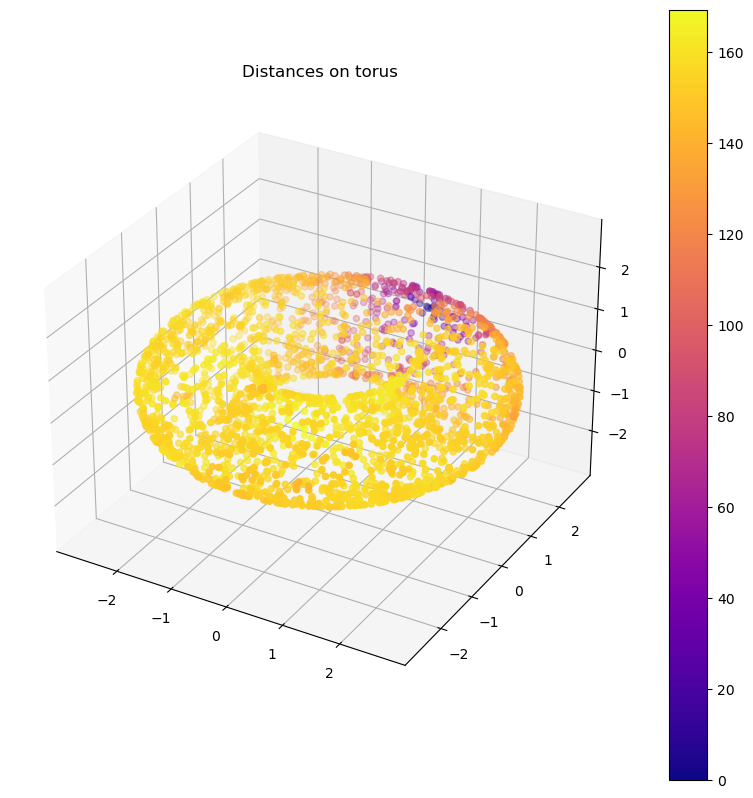

In [ ]:
plot_3d(X_torus,G_torus.D[3], "Distances on torus", colorbar=True)

## The Wasserstein Diffusion Curvature
This has two components: computing the spread of diffusion, and computing a "flattened facsimile" of the graph. 

For the second, we presently give a naive implementation that presumes the dimensionality is known and constructs random noise of the same dimension and size.

In [4]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature.wasserstein_spread_of_diffusion)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L58){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature.wasserstein_spread_of_diffusion

>      DiffusionCurvature.wasserstein_spread_of_diffusion
>                                                          (G:graphtools.base.Da
>                                                          taGraph, idx=None)

Returns how "spread out" each diffusion is, with wasserstein distance"
Presumes that the manifold distances have been separately calculated
If idx is passed, only computes wsd at that index

In [ ]:
DC.wasserstein_spread_of_diffusion(G_torus)

array([33.31076715, 32.4294289 , 41.01191395, ..., 35.27916715,
       42.93821445, 33.89898037])

To create a flattened graph as similar as possible to the original, we need to use the same graphtools parameters as used to initialize `G`. Most of these, fortunately, are easily accessible. Some - like the type of graph - require reverse engineering.

In [ ]:
G_exact = graphtools.Graph(X_torus, graphtype='exact')
# G_mnn = graphtools.Graph(X_torus, graphtype='mnn')
G_knn = graphtools.Graph(X_torus, graphtype='knn')

In [5]:
#| echo: false
#| output: asis
show_doc(get_graph_type)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L79){target="_blank" style="float:right; font-size:smaller"}

### get_graph_type

>      get_graph_type (G)

In [ ]:
test_eq('knn', get_graph_type(G_knn))
test_eq('exact', get_graph_type(G_exact))

The other parameters are either stored in the

In [ ]:
G_torus.get_params()

{'n_pca': None,
 'random_state': None,
 'kernel_symm': '+',
 'theta': None,
 'anisotropy': 1,
 'knn': 5,
 'decay': 40,
 'bandwidth': None,
 'bandwidth_scale': 1.0,
 'knn_max': None,
 'distance': 'euclidean',
 'thresh': 0.0001,
 'n_jobs': -1,
 'verbose': False}

function, or can be safely set to None.

In [6]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature.flattened_facsimile_of_graph)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L88){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature.flattened_facsimile_of_graph

>      DiffusionCurvature.flattened_facsimile_of_graph
>                                                       (G:graphtools.base.DataG
>                                                       raph, dimension)

Constructs a flat graph, hewn from uniform random noise of the supplied dimension.
Calculates the powered diffusion matrix on this graph.

In [ ]:
G_flattened = DC.flattened_facsimile_of_graph(G_torus,dimension=2)

This is an alternate measurement of a diffusion's "spread". 

In [7]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature.entropy_of_diffusion)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L129){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature.entropy_of_diffusion

>      DiffusionCurvature.entropy_of_diffusion (G:graphtools.base.DataGraph,
>                                               idx=None)

Returns the pointwise entropy of diffusion from the powered diffusion matrix in the inpiut

At last, we can assemble all of this into a curvature definition.
The steps are:
1. Precompute $P^t$ and $D$.
2. Estimate the local dimension of each point, unless a dimension is given, in which case we assume it is the global dimension.
3. Construct a flattened graph for each of the distinct local dimensions. Compute the spread of the diffusion there and on the actual data. Take the difference. Huzzah - It's diffusion curvature.

In [8]:
#| echo: false
#| output: asis
show_doc(DiffusionCurvature.curvature)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L146){target="_blank" style="float:right; font-size:smaller"}

### DiffusionCurvature.curvature

>      DiffusionCurvature.curvature (G:graphtools.base.DataGraph, t=None,
>                                    dimension:int=None)

Computes diffusion curvature of input graph. Stores it in G.ks

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| G | DataGraph |  | A graphtools graph to compute the curvature of |
| t | NoneType | None | The number of steps within the random walks. Corresponds to how local/global the curvature estimate is. |
| dimension | int | None | If supplied, the global manifold dimension. If not supplied, estimates the local dimension of each point. |

In [ ]:
G_torus.D[0]

array([  0.        , 146.6362567 , 153.9091748 , ..., 151.88239136,
       158.17859662,  43.81179214])

In [ ]:
G_torus = DC.curvature(G_torus,dimension=2)

In [9]:
#| echo: false
#| output: asis
show_doc(plot_manifold_curvature)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/graphtools.py#L188){target="_blank" style="float:right; font-size:smaller"}

### plot_manifold_curvature

>      plot_manifold_curvature (G, title=None)

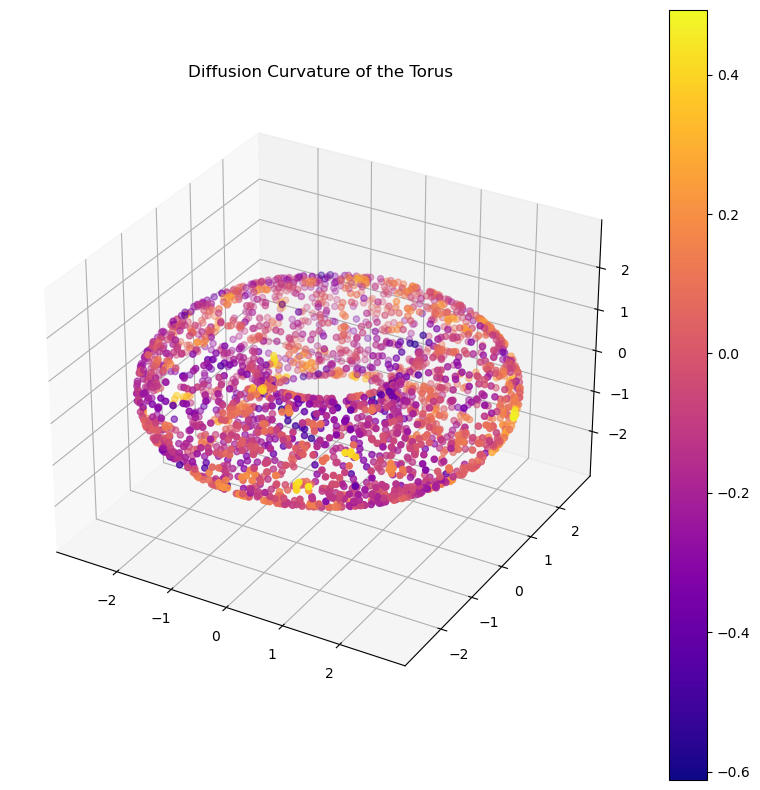

In [ ]:
plot_manifold_curvature(G_torus,"Diffusion Curvature of the Torus")

# Use on Data
To compute the wasserstein diffusion curvature of the data, first put the data into your `ManifoldGraph` object. Supply the dimension of the data, if you know it. Also select the parameters for creating an affinity matrix: the kernel type, the number of neighbors to use, and the degree of anisotropic density normalization.

If you're unsure what value to put for any of these, leave it blank. We'll use heuristics to find a good value for t and use our own dimension fitting to find a good value for that.

Alternately, if already have a graph (A), or any other piece of the puzzle, just supply it as an argument when initializing the `ManifoldGraph` class.

In [ ]:
G_torus = graphtools.Graph(X_torus, anisotropy=1, knn=30)

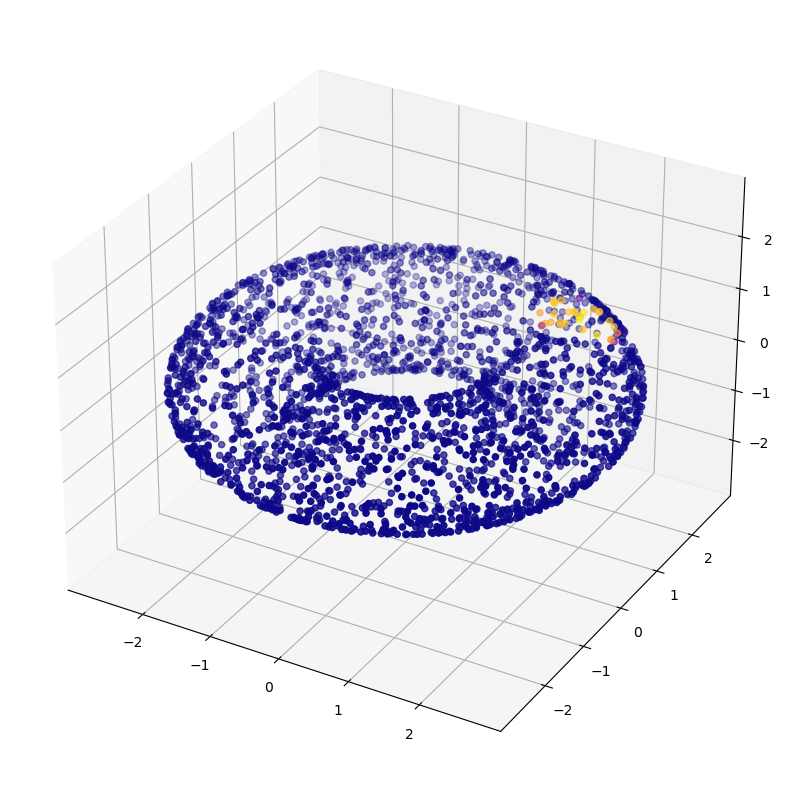

In [ ]:
plot_3d(X_torus, G_torus.P[0].toarray())

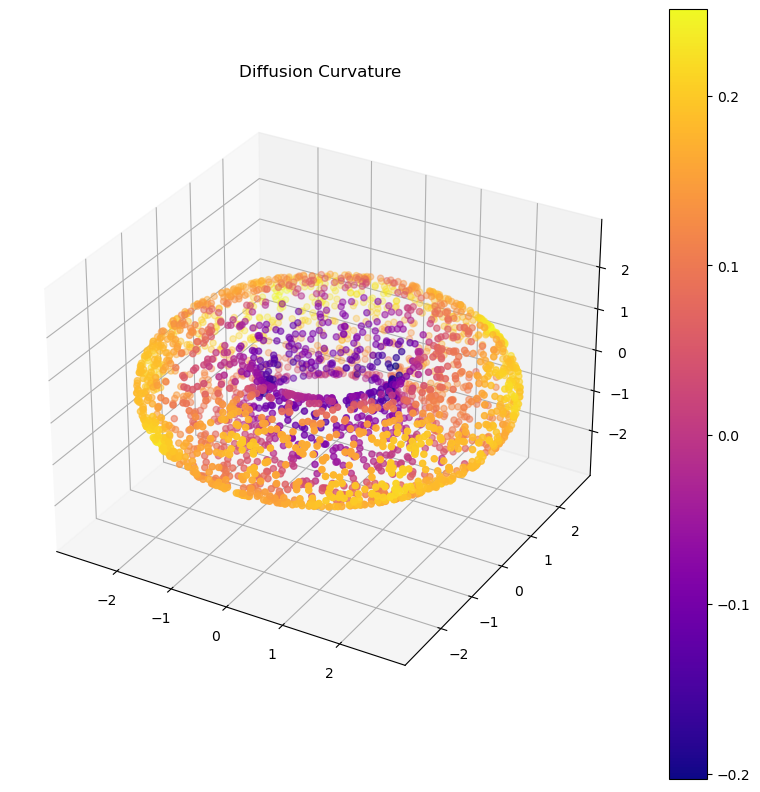

In [ ]:
DC = DiffusionCurvature(t=12)
G_torus = DC.curvature(G = G_torus, dimension=2)
plot_manifold_curvature(G_torus, title="Diffusion Curvature")

In [ ]:
G_torus = DC.power_diffusion_matrix(G_torus, t=20)

CPU times: user 23.6 s, sys: 11.2 ms, total: 23.6 s
Wall time: 23.6 s
